## Null Hypothesis (NH)

- asking yes or no questions (nongaussian, mean nonzero, correlation, nonlinearity in correlation, chaos)
- aim is to disprove the opposite. This opposite is the Null Hypothesis
- accept and reject the hypothesis, by showing, that the data are unlike/like results from the hypothesis
- for that discriminating statistics $T$ is calculated
- rejecting the null hypothesis means, that if it were true it is unlikely this value would be observed


|             | $H_0$ |  $H_1$ |
| ----------- | ----------- | ----------- |
| Result $H_0$      | correct       | Typ II error ($\beta$ error) |
| Result $H_1$    | Type I error ($\alpha$ error)        | correct |

- *size* $\alpha$ corresponds to acceptance rate normally set to $\alpha=0.05$
-  $1-\beta$ is the *power* of the test and influenced by underlying process and $n$

Distinguish between **simple** and **composite** NH:
let $\mathcal{F}$ be the space of considered processes and $\mathcal{F}_\phi \subset \mathcal{F}$ the processes, which are consistent with NH. If there are just one process $F\in\mathcal{F}_\phi$ then the HM is simple, otherwise its composite. In composite case, the NH just say that there are some process $F\in\mathcal{F}_\phi$, but not which process specific. 


## Monte Carlo
- need to set confidence interval of $T$ to $95\%$ i.e. $\alpha=0.05$
  - straightforward possible with standard distributions  
- to calculate this for any distribution Monte Carlo technics are useful
    - compute many random realizations of the NH and compute $T$
    - measure resulting distribution
- measuring confidence intervals give error bars for a statistic of the data like the mean or the fractal dimension
- other possibility is to test if the data are consistent with the hypothesis.


## Surrogates

- create multiple versions of a given time series with same statistical properties
- two main types
  - **typical realizations:** fit a model the data and vary the noise
    - problems occurs if NH is composite, then its not clear which process should be simulated 
    - to avoid this $T$ has to be **pivotal** i.e. the distribution of $T$ is the same $\forall F \in \mathcal{F}_\phi$
    - often only given in the limit $n\to\infty$
  - **constrained realizations:** produce surrogates directly from the data by conserving all properties except the one that should be tested
    - behaves like $T$ is pivotal even its not, so they can used more widely for different NH
    - just for NH not for confidence intervals
- number of surrogates $M=\frac{K}{1-\alpha}$ for $K$ is a positiv integer. For a two sided test, $K$ should be at least 2 [Lancaster2018](https://reader.elsevier.com/reader/sd/pii/S0370157318301340?token=9C5C6E84692DF478CBE66439D8A646FA785D0C739620C900446EF6C9E220346F673C48C1F6683226444D2C303B2829F3&originRegion=eu-west-1&originCreation=20221215170415)


In [1]:
from pytisean import tiseano, tiseanio
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss

def autocorrelation(x): 
    # -p for periodic continuation
    result, msg = tiseanio('/home/luca/bin/autocor', '-p', data=x, silent=True)
    return result[:,1]

def powerspektrum(x):
    result, msg = tiseanio('/home/luca/bin/spectrum', data=x, silent=True)
    return result[:,0], result[:,1]


In [2]:
# # creating an AR2 Timeseries
parameter = np.array([1,0.33,0.5,1])

ar2_data, msg = tiseanio('/home/luca/bin/ar-run', '-l5000', '-p2', data=[1,0.33,0.5,1]
, silent=True)

def plot_surrogates(time_series, surrogate_method):
    time_series_surrogate = surrogate_method(time_series)
    fig, axs = plt.subplots(4, )
    fig.set_size_inches(5,10)
    mean = np.mean(time_series)
    std = np.std(time_series)
    mean_surrogate = np.mean(time_series_surrogate)
    std_surrogate = np.std(time_series_surrogate)
    axs[0].set_title("Timeseries")
    axs[0].plot(time_series, label=f"Original: mean={mean:.2f}, std={std:.2f}")
    axs[0].plot(time_series_surrogate, label=f"Surrogate: mean={mean_surrogate:.2f}, std={std_surrogate:.2f}")
    axs[0].set_xlabel("time steps")
    axs[0].set_ylabel("value")
    axs[1].set_title("Autocorrelation")
    axs[1].plot(autocorrelation(time_series))
    axs[1].plot(autocorrelation(time_series_surrogate))
    axs[2].set_title("Power Spectrum")
    f, Pxx = powerspektrum(time_series) # calculate power spectrum
    axs[2].plot(f, Pxx)
    f_s, Pxx_s = powerspektrum(time_series_surrogate)
    axs[2].plot(f_s, Pxx_s)
    axs[2].set_xlabel("frequencys")
    axs[2].set_ylabel("power")
    axs[3].hist(time_series)
    axs[3].hist(time_series_surrogate)
    axs[3].set_xlabel("values")
    axs[3].set_ylabel("occurance")
    fig.legend()
    fig.tight_layout()
    plt.plot()
    return



### Testing for IID (idependent and identically distributed) data

Used to find out if data are just white Gaussian noise or test for non-Gaussian distribution

**Null Hypothesis**: The data are independent and identically distribution 

**Surrogate Methode**: Random Shuffle (RS)

**Algorithm**: permute the values of the time series random

- mean and standard derivation and value histogram are preserved while every correlation are destroyed. 

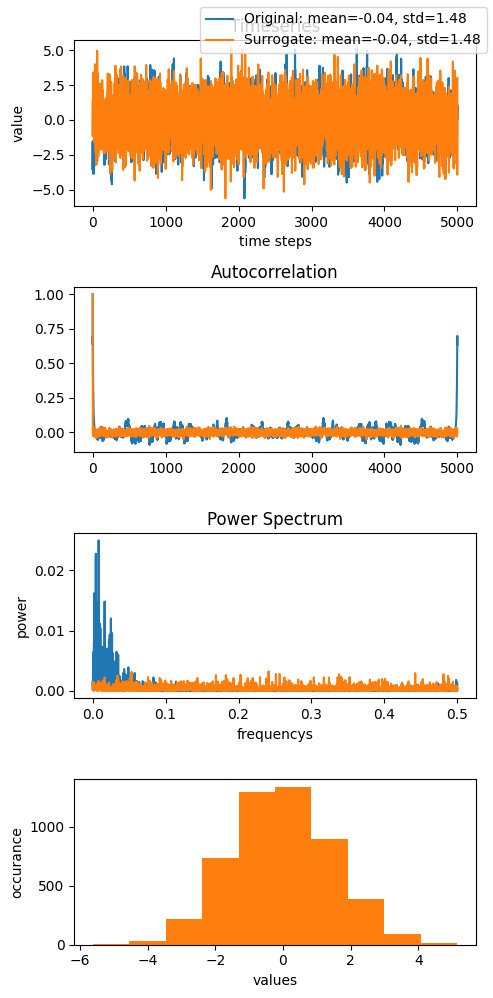

In [3]:
def RS(timeseries):
    """
        shuffles the values of the time series
    """
    RS_surrogate = np.copy(timeseries)
    np.random.shuffle(RS_surrogate)
    return RS_surrogate

plot_surrogates(ar2_data, RS)


**discriminating statistic** e.g. Autocorrelation at lag 1:

\begin{gather}
T = A(1) = \frac{1}{n-1} \sum_{i=0}^{n}(x(i)-\overline{x})\frac{(x(i+1)-\overline{x})}{\overline{(x-\overline{x})^2}} \quad \text{with} \quad \overline{(x-\overline{x})^2} = \sqrt{\frac{1}{n}\sum_{i=0}^n (x(i)-\overline{x})^2}
\end{gather}


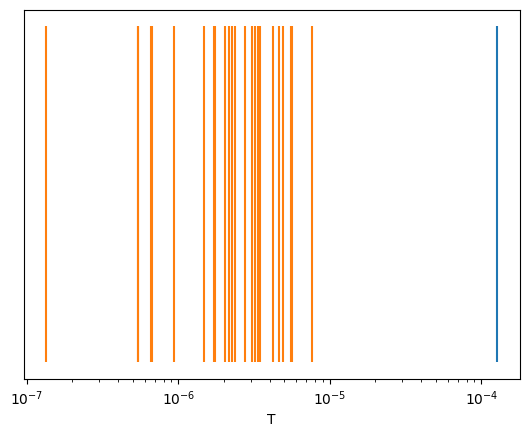

In [4]:
def A1(x):
    n = x.shape[0]
    # print(n)
    mu = x.mean()
    denominator = 0 
    for i in range(n):
        denominator += (x[i]-mu)**2
    denominator/n

    result = 0
    for i in range(n):
        result += (x[i]-mu)*(x[(i+1)%n]-mu)/denominator
    return result/(n-1)

plt.vlines(A1(ar2_data),0,1, color='tab:blue')

T_values = []
for i in range(39):
    surr = RS(ar2_data)
    T_value = A1(surr)
    T_values.append(T_value)
    plt.vlines(T_value,0,1, color='tab:orange')

# plt.hist(T_values)    

plt.xlabel("T")
plt.xscale('log')
plt.yticks([])
plt.show()

## Testing for Nonlinearity

- bevor apply techniques for analysis nonlinear systems, this methods must be justified by non linearity in the time series.
- chaos can't be directly proven in a time series, nonlinearity can. And since chaos implies nonlinearity it can be at least disproven. 

- Random shuffling is not useful instead techniques are needed that preserve the autocorrelation function of the original data. 
  
**Null Hypothesis**: Data generated by linear stationary process probably with noise and can be fully characterized by *mean*, *standard deviation* and autocorrelation. 
    - this means that rejecting the NH could also mean, that the process is linear but nonstationarity
    - nonstationarity i.e. that the statistical properties are invariant has to be proven beforehand
      - wavelet based surrogates, that preserve the local mean and variance are useful for testing nonstationarity
      - in the following stationary time series are assumed 

- After the Wiener-Khinchin theorem preserving the periodic autocorrelation the power spectrum is also preserved
 

## Preprocessing 
todo anschauen: https://www.pks.mpg.de/tisean/TISEAN_2.1/docs/docs_f/test.html
  - removing trends that are not important todo 
  - correct any mismatch between start and endpoints for the data and the first derivatives i.e. the number of periods of oscillations has to be an integer
    - otherwise this cause a numerical artifact and the Fourier based surrogate has perturbations s.t. a linear signal can look nonlinear
    - the match can be achieved by truncate the signal
  - subtract the mean

In [6]:
endtoend, msg = tiseanio('/home/luca/bin/endtoend', data=ar2_data, silent=True)

ValueError: the number of columns changed from 7 to 3 at row 2; use `usecols` to select a subset and avoid this error

### FT

Null Hypothesis: data come from linear gaussian prozess

- FFT
- random phases $\phi$ s.t. $\phi(f)=-\phi(-f)$ 
- IFFT


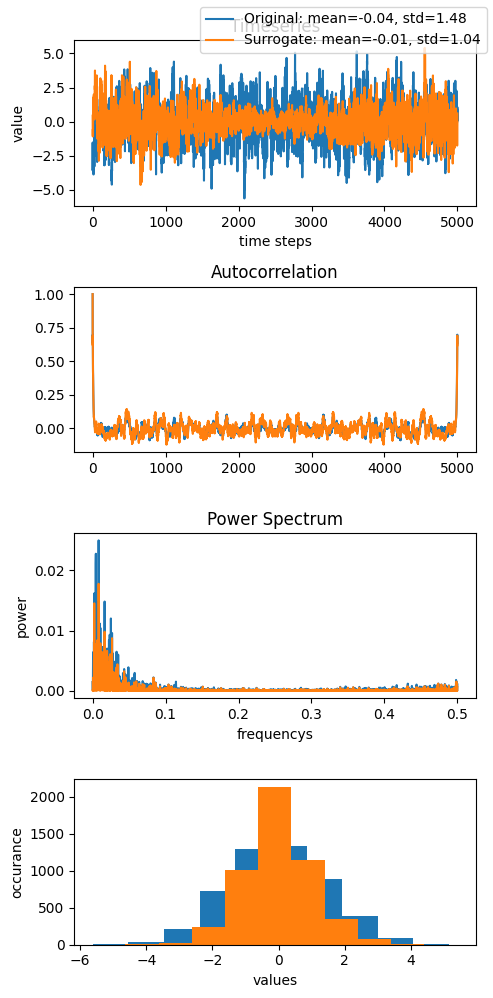

In [ ]:
def FS_phase(timeseries):
    ft = np.fft.fft(timeseries)
    phase = np.angle(ft) #phase of the complex fourier values
    # print(np.imag(ft))
    amp = np.abs(ft) # amplitudes of the complex fourier values
    # print(amp)

    n = len(ft)
    # constrained that phi(f) = -phi(-f) that ifft is real
    if n % 2 == 0:
        half_phase = np.random.uniform(0,2*np.pi, n//2)
        phase = np.append(half_phase, -np.flip(half_phase))
    else:
        half_phase = np.random.uniform(0,2*np.pi, n//2+1)
        phase = np.append(0, np.append(half_phase[:-1], np.append([half_phase[-1]], -np.flip(half_phase[:-1]))))

    # amp
    # amp = np.append(0,amp)
    value = np.fft.ifft( amp* np.exp(phase*1j))
    # print(value)
    return np.real(value) # todo img actually not zero

plot_surrogates(ar2_data, FS_phase)

Possible extension to **truncated Fourier transform surrogate** which has a frequency threshold. Under this threshold the $\phi$ stay the same above $\phi$ are randomized, so just long-term trends are preserved while short-term variability is randomized. So nonlinearity can be observed even though there are short-term fluctuations.

### AAFT

Null Hypothesis:
underlaying time series $\{y_i\}$ consistent with the null hypothesis of linear gaussian noise. The observed time series $\{x_i\}$ is given by $x_i = h(y_i)$. Monotonic nonlinear transformation of a linear gaussian process.

- rescale values to be gaussian
- apply FT (same Fourier spectrum)
- rescale back to have same amplitude distribution

[-1.59766316 -3.57441282 -2.21568108 ...  0.05311915  1.07428265
  0.10019647]
[2080 2079 2077 ... 3762 2774 3620]
[ 0.95846113 -0.22321276  0.83528034 ... -2.20311402 -0.45964955
  1.15670297]


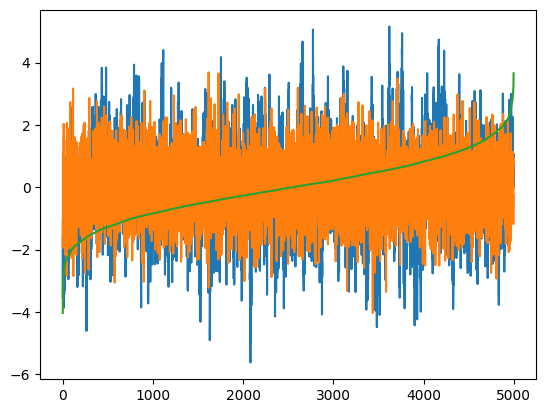

In [ ]:
def AAFT(timeseries):
    n = len(timeseries)
    print(timeseries)
    indices_timeseries = np.argsort(timeseries)
    print(indices_timeseries)
   


    # print(timeseries)
    y = np.random.normal(0,1,n)
    indices_y = np.argsort(y)
    
    print(y)
    # plt.plot(y)
    
    plt.plot(timeseries)
    y = y[indices_timeseries]
    plt.plot(y)
    # plt.hist(y)
    # print(y[indices])

    sorted_timeseries = np.sort(timeseries)

    y = y[np.argsort(y)[:-1]] 
    # print(y)
    plt.plot(y)
    # print(y)

AAFT(ar2_data)

### IAAFT

Share distribution and power spectrum

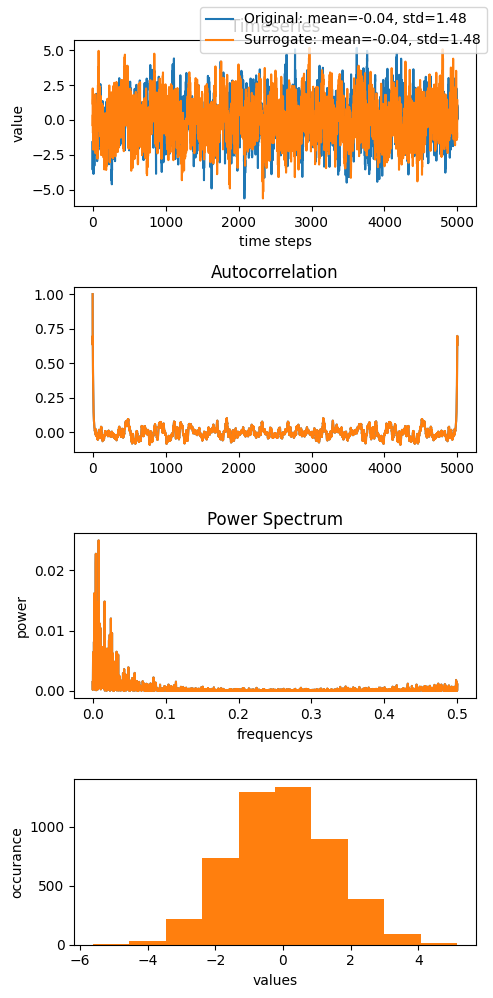

In [ ]:
def IAAFT(timeseries):
    IAAFT_surr, msg = tiseanio('/home/luca/bin/surrogates', silent=True, data=timeseries)
    # print(IAAFT_surr)
    return IAAFT_surr

plot_surrogates(ar2_data, IAAFT)

chaos requires nonlinearity

Null Hypothessi linear, Gaussian, stationary stochasitc process (important to insure, that the data are stationary (statistical properties dosent change))

## Testing for nonlinearity

**Null Hypothesis:** data arise from a linear stochastic process



In [ ]:
henon, msg = tiseano('/home/luca/bin/henon', '-l1000', silent=True)

def T(x):
    n = x.shape[0]
    numerator = 0
    denominator = 0
    for i in range(n):
        numerator += (x[(i+1)%n]-x[i])**3 
        denominator += (x[(i+1)%n]-x[i]**2)
    numerator/=n
    denominator/=n 
    print(numerator)
    print(denominator)
    result = numerator / (denominator)**(3/2) + 20*A1(x)
    print(f"res = {result}")
    return result

print(T(henon[:,0]))

# print(henon[:,0])

-1.1144593399939173
-0.32728330921363924
res = nan
nan


/tmp/ipykernel_569060/3389423043.py:14: RuntimeWarning: invalid value encountered in double_scalars
  result = numerator / (denominator)**(3/2) + 20*A1(x)


## Delay-coordinate embedding

- helpful if the measurement contains e.g. just x-data
- reconstructing space from one axis of the phase space 

with $x(t), x(t-\tau), x(t-2\tau), \ldots$ as axis

### Takens's Theorem
For the right $\tau$ and enough dimensions $m$ the embedded dynamics have the same topology as the original state-space dynamics

### Correlation Dimension

***pointwise dimension*** $d_\mathrm{p}$: number of points $N_x(\varepsilon)$ within $\varepsilon$ around a point $x$
\begin{gather}
N_x(\varepsilon) \propto \varepsilon^{d_\mathrm{p}}
\end{gather}

***correlation dimension*** $d_\mathrm{corr}$: average $N_x(\varepsilon)$ over lots of $x$: $N_x(\varepsilon)\to C(\varepsilon)$

\begin{gather}
C(\epsilon) \propto \varepsilon^{d_\text{corr}}
C(\varepsilon) =\frac{1}{N(N-1)} \sum_{i=1}^N\sum_{j=i+1}^N \Theta(\varepsilon-||x_i-x_j||)\\
\end{gather}


[-1.59766316 -3.57441282 -2.21568108 ...  0.05311915  1.07428265
  0.10019647]
[ 0.65303069  0.3560828   1.01839626 -0.34515849  1.13873076 -0.91893834
  0.15939252  0.68875015  0.38369036  1.00051939 -0.28634769  1.18536282
 -1.05302334 -0.1967926   0.62987471  0.3855232   0.980883   -0.23132713
  1.21934783 -1.15093076 -0.4886938   0.32037049  0.70969969  0.39096802
  0.99891156 -0.27966356  1.19017708 -1.06702912 -0.23691854  0.6013087
  0.42272344  0.93021947 -0.08461449  1.26904237 -1.28004038 -0.9131918
 -0.55149913  0.30023065  0.70835644  0.38759282  1.00218749 -0.28985372
  1.18303502 -1.04635668 -0.17789653  0.64178693  0.36998436  1.00089228
 -0.2915042   1.18130314 -1.0411191  -0.16310957  0.65041763  0.35880679
  1.01488602 -0.33434913  1.14796078 -0.94524413  0.09350713  0.70418572
  0.33382359  1.0552423  -0.45880359  1.02187169 -0.59955144  0.8033148
 -0.08330593  1.23127866 -1.1474576  -0.47393885  0.34129748  0.69474077
  0.4266586   0.95356965 -0.14501558  1.25662959

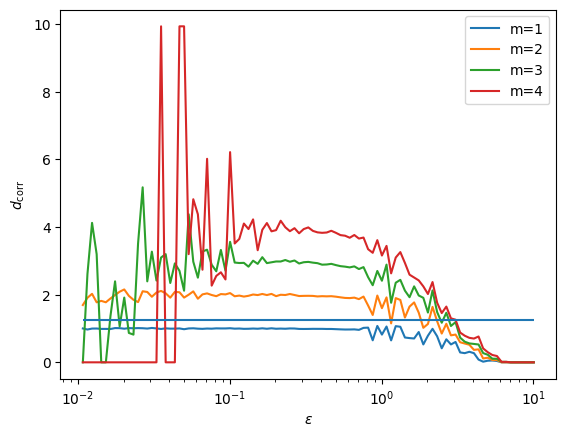

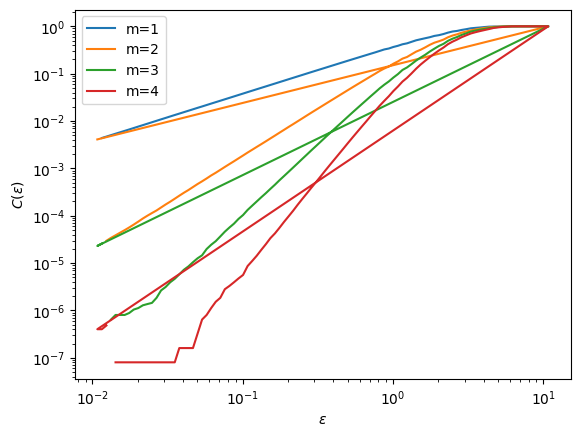

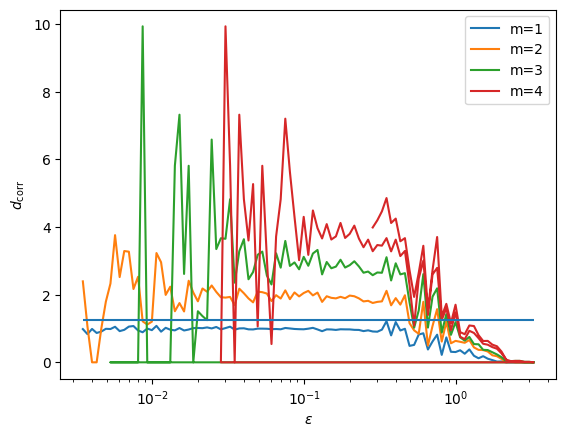

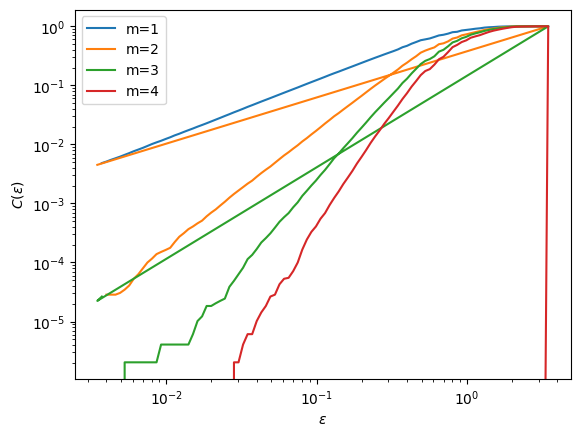

In [ ]:
# d2, msg = tiseanio('/home/luca/bin/d2', data=henon[:,0], silent=True)

print(ar2_data)
print(henon[:,0])

d2, msg = tiseanio('/home/luca/bin/d2', data=ar2_data, silent=True)

corr_dim = d2[0]
corr_sum = d2[1]

dim = np.arange(0, len(corr_dim), 99)

for i in range(4):
    plt.plot(corr_dim[dim[i]:dim[i+1],0], corr_dim[dim[i]:dim[i+1],1], label=f"m={i+1}")

plt.hlines(1.25, min(corr_dim[:,0]), max(corr_dim[:,0]))
plt.xscale('log')
plt.xlabel("$\\varepsilon$")
plt.ylabel("$d_\mathrm{corr}$")
plt.legend()
plt.show()

for i in range(4):
    plt.plot(corr_sum[dim[i]:dim[i+1],0], corr_sum[dim[i]:dim[i+1],1], label=f"m={i+1}")

# plt.hlines(1.25, min(corr_sum[:,0]), max(corr_sum[:,0]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("$\\varepsilon$")
plt.ylabel("$C(\\varepsilon)$")
plt.legend()
plt.show()

# Surogates

sur_henon = FS_phase(henon[:,0])

d2, msg = tiseanio('/home/luca/bin/d2', data=sur_henon, silent=True)

corr_dim = d2[0]
corr_sum = d2[1]

dim = np.arange(0, len(corr_dim), 99)

for i in range(4):
    plt.plot(corr_dim[dim[i]:dim[i+1],0], corr_dim[dim[i]:dim[i+1],1], label=f"m={i+1}")

plt.hlines(1.25, min(corr_dim[:,0]), max(corr_dim[:,0]))
plt.xscale('log')
plt.xlabel("$\\varepsilon$")
plt.ylabel("$d_\mathrm{corr}$")
plt.legend()
plt.show()

for i in range(4):
    plt.plot(corr_sum[dim[i]:dim[i+1],0], corr_sum[dim[i]:dim[i+1],1], label=f"m={i+1}")

# plt.hlines(1.25, min(corr_sum[:,0]), max(corr_sum[:,0]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("$\\varepsilon$")
plt.ylabel("$C(\\varepsilon)$")
plt.legend()
plt.show()


### Surrogate technics for EEG data 
todo
- EEG data chaotic according to many studies
- used for epilepsy patients shows that nonlinear methods in combination with surrogates had higher accuracy
